In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal

In [2]:
s_win = 256 # window size
n_channel = 128 # number of different filters, each filter has a w_k
s_block = 4 * s_win # computation block size, must be multiple of s_win
DAFx_in, FS = sf.read('audios/la.wav')
print(DAFx_in.shape)

(22054,)


In [3]:
window = signal.windows.hann(s_win, sym=False) # periodic hann window function
s_buffer = len(DAFx_in) # buffer length

DAFx_in = np.concatenate((DAFx_in, np.zeros(s_block))) / np.max(np.abs(DAFx_in))
DAFx_out = np.zeros(len(DAFx_in))

X = np.zeros((s_block, n_channel), dtype='complex128')
z = np.zeros((s_win - 1, n_channel), dtype='complex128') # initial conditions for the filter

In [4]:
t = np.arange(s_block)
het = np.zeros((s_block, n_channel), dtype='complex128')
het2 = np.zeros((s_block, n_channel), dtype='complex128')

for k in range(1, n_channel + 1):
    wk = 2j * np.pi * (k/s_win)
    # W_N^{-nk} * e^{j*np.pi*k} = (-1)^k * W_N^{-nk} => oscilador em wk
    het[:, k - 1] = np.exp(wk * (t.astype(float) + s_win/2))
    # transformacao para X_tilde
    het2[:, k - 1] = np.exp(-wk * t.astype(float))

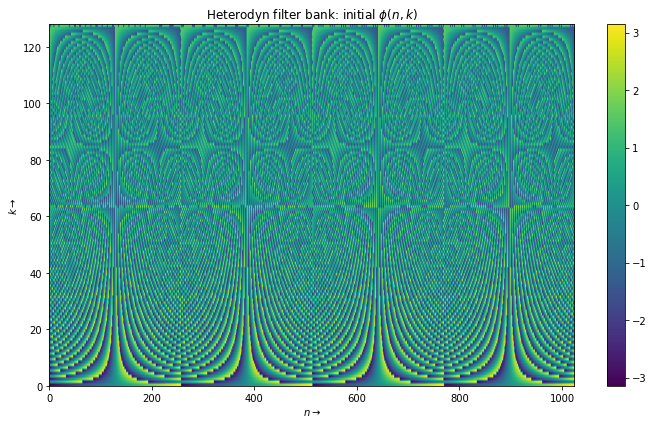

In [5]:
plt.figure(figsize=(10, 6))
plt.subplot(111)
plt.imshow(
    np.conj(np.angle(het).T),
    extent=[0, s_block, 0, n_channel],
    aspect='auto',
    origin='lower'
)
plt.title(r'Heterodyn filter bank: initial $\phi(n,k)$')
plt.xlabel(r'$n \rightarrow$')
plt.ylabel(r'$k \rightarrow$')
plt.colorbar()
plt.tight_layout()

In [6]:
pin  = 0
pend = len(DAFx_in) - s_block

while (pin < pend):
    grain = DAFx_in[pin:(pin + s_block)]

    # filtering
    for k in range(n_channel):
        # b => window
        # a => 1
        # x => grain * het[:, k]
        # initial conditions => z[:, k] => turns into final filter delays after lfilter
        X[:, k], z[:, k] = signal.lfilter(window, 1, grain * het[:, k], axis=0, zi=z[:, k])
    X_tilde = X * het2
    
#     plt.figure(figsize=(10, 6))
#     plt.subplot(111)
#     plt.imshow(
#         np.angle(np.conj(X_tilde.T)),
#         extent=[0, s_block, 0, n_channel],
#         aspect='auto',
#         origin='lower'
#     )
#     plt.title(fr'Complex-valued filter bank: $\phi(n,k)$, t={(pin + 1)/FS:6.3f} s')
#     plt.xlabel(r'$n \rightarrow$')
#     plt.ylabel(r'$k \rightarrow$')
#     plt.colorbar()
#     plt.tight_layout()
    
    # sound reconstruction
    res = np.real(np.sum(X_tilde, axis=1))
    DAFx_out[pin:(pin + s_block)] = res
    pin = pin + s_block

In [7]:
DAFx_out = DAFx_out[n_channel:n_channel+s_buffer] * np.max(np.abs(DAFx_in))/ np.max(np.abs(DAFx_out))
print(DAFx_out.shape)
sf.write('audios/la_het_nothing.wav', DAFx_out, FS)

(22054,)
